In [13]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/albaniolivieri/Documents/UCSD classes/1st year/winter quarter


In [67]:
from pathlib import Path
from parfive import Downloader
import numpy as np
import scipy.linalg as la
import pandas as pd
# from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
# from notebook_functions import *
# from hux_code.numerical_methods import apply_numerical_method
# from hux_code.hux_propagation import apply_hux_f_model
import time
import astropy.units as u

In [57]:
def apply_hux_f_model(initial_condition, dr_vec, dp_vec, r0=30 * 695700, alpha=0.15, rh=50 * 695700, add_v_acc=True,
                      omega_rot=(2 * np.pi) / (25.38 * 86400)):
    """Apply 1d upwind model to the inviscid burgers equation.
    r/phi grid. return and save all radial velocity slices.

    :param initial_condition: 1d array, initial condition (vr0). units = (km/sec).
    :param dr_vec: 1d array, mesh spacing in r. units = (km)
    :param dp_vec: 1d array, mesh spacing in p. units = (radians)
    :param alpha: float, hyper parameter for acceleration (default = 0.15).
    :param rh: float, hyper parameter for acceleration (default r=50*695700). units: (km)
    :param r0: float, initial radial location. units = (km).
    :param add_v_acc: bool, True will add acceleration boost.
    :param omega_rot: differential rotation.
    :return: velocity matrix dimensions (nr x np)
    """
    v = np.zeros((len(dr_vec) + 1, len(dp_vec) + 1))  # initialize array vr.
    v[0, :] = initial_condition

    if add_v_acc:
        v_acc = alpha * (v[0, :] * (1 - np.exp(-r0 / rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):

            if j == len(dp_vec):  # force periodicity
                v[i + 1, j] = v[i + 1, 0]

            else:
                if (omega_rot * dr_vec[i]) / (dp_vec[j] * v[i, j]) > 1:
                    print(dr_vec[i] - dp_vec[j] * v[i, j] / omega_rot)
                    print(i, j)  # courant condition

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1 * frac2
    return v


In [7]:
def convert_from_x_to_v(X_ROM, r, p, m, b, shift_function, method="cce"):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    for jj in range(1, len(r)):
        # find shift based on linear fit.
        shift = shift_function(r[jj].to(u.AU).value, r_idx=jj, m=m, b=b, method=method)
        # interpolate over shifted coords.
        V_ROM[:, jj] = np.interp(p - shift*(np.pi/180), p, X_ROM[:, jj], period=2*np.pi)
    return V_ROM


def regularizer(r, λ1, λ2):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.

    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r * (r + 1) // 2

    diag𝚪 = np.full(r2 + 1, λ1)
    diag𝚪[r1:-1] = λ2
    return diag𝚪

In [8]:
def get_mas_path(cr, folder="hmi_mast_mas_std_0201"):
    """Get MAS website results.

    :param cr: carrington rotation. ex: 2210
    :return: mas_path
    """
    download_dir = Path.cwd() / '..' / '..' / 'data'
    
    cr_string = 'mas_helio/cr' + str(cr)
    mas_helio_dir = download_dir / cr_string 
    mas_helio_dir.mkdir(parents=True, exist_ok=True)

    base_url = 'http://www.predsci.com/data/runs/cr' + str(cr) + '-medium/' + folder + '/helio/{var}002.hdf'

    # Create a downloader to queue the files to be downloaded
    dl = Downloader()

    for var in ['rho', 'vr', 'br']:
        file = mas_helio_dir / f'{var}002.hdf'
        if file.exists():
            continue
        else:
            remote_file = base_url.format(var=var)
            dl.enqueue_file(remote_file, path=mas_helio_dir)

    # Download the files
    if dl.queued_downloads > 0:
        dl.download()
    return mas_helio_dir.resolve()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [18]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
# read in MHD velocity results. 
vr_model = model['vr']

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]









































Files Downloaded: 100%|██████████| 3/3 [00:01<00:00,  1.86file/s]


In [84]:
# vr_model.data
vr_model.data.isel(time=0, drop=True)

<xarray.DataArray 'vr' (phi: 128, theta: 111, r: 140)> Size: 8MB
array([[[650.     , 655.65656, 661.8273 , ..., 757.87775, 757.9674 ,
         757.9974 ],
        [650.     , 655.6601 , 661.8414 , ..., 757.87836, 757.9694 ,
         757.99915],
        [650.     , 655.6907 , 661.9009 , ..., 757.8859 , 757.99426,
         758.0185 ],
        ...,
        [650.     , 655.6573 , 661.84845, ..., 757.86487, 757.9633 ,
         757.99194],
        [650.     , 655.6634 , 661.85754, ..., 757.86536, 757.9494 ,
         757.9798 ],
        [650.     , 655.6699 , 661.87024, ..., 757.86523, 757.9484 ,
         757.978  ]],

       [[650.     , 655.6568 , 661.8279 , ..., 757.87775, 757.96735,
         757.9974 ],
        [650.     , 655.6601 , 661.841  , ..., 757.8784 , 757.9695 ,
         757.99915],
        [650.     , 655.68964, 661.9009 , ..., 757.88605, 757.9945 ,
         758.01886],
...
        [650.     , 655.6568 , 661.84576, ..., 757.86566, 757.9643 ,
         757.9927 ],
        [650.     , 655.6627 , 661.85626, ..., 757.8655 , 757.9496 ,
         757.9799 ],
        [650.     , 655.67   , 661.871  , ..., 757.86523, 757.94836,
         757.978  ]],

       [[650.     , 655.6562 , 661.8266 , ..., 757.87775, 757.96747,
         757.99744],
        [650.     , 655.66   , 661.8416 , ..., 757.8783 , 757.96936,
         757.999  ],
        [650.     , 655.69073, 661.8995 , ..., 757.8856 , 757.9938 ,
         758.01807],
        ...,
        [650.     , 655.65704, 661.84705, ..., 757.86523, 757.9637 ,
         757.9923 ],
        [650.     , 655.663  , 661.8569 , ..., 757.8654 , 757.9495 ,
         757.97986],
        [650.     , 655.6699 , 661.87067, ..., 757.86523, 757.9484 ,
         757.978  ]]], dtype=float32)
Coordinates:
  * phi      (phi) float64 1kB 0.0 0.04909 0.09817 0.1473 ... 6.136 6.185 6.234
  * theta    (theta) float64 888B -1.585 -1.556 -1.528 ... 1.528 1.556 1.585
  * r        (r) float64 1kB 30.0 31.49 32.97 34.46 ... 232.0 233.5 235.0 236.5

In [85]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
# r = (vr_model.r_coords * u.solRad).to(u.km) 
# velocity profile 
f = vr_model.data.isel(time=0, drop=True)
print(f.shape)

(128, 111, 140)


In [ ]:
# u.solRad
r = (vr_model.r_coords).to(u.km) 
r

<Quantity [2.08710000e+07, 2.19043392e+07, 2.29376784e+07, 2.39710189e+07,
           2.50043594e+07, 2.60376999e+07, 2.70710377e+07, 2.81043782e+07,
           2.91377187e+07, 3.01710566e+07, 3.12043971e+07, 3.22377376e+07,
           3.32710754e+07, 3.43044159e+07, 3.53377565e+07, 3.63710970e+07,
           3.74044348e+07, 3.84377753e+07, 3.94711158e+07, 4.05044537e+07,
           4.15377942e+07, 4.25711347e+07, 4.36044752e+07, 4.46378130e+07,
           4.56711509e+07, 4.67044940e+07, 4.77378319e+07, 4.87711751e+07,
           4.98045129e+07, 5.08378508e+07, 5.18711939e+07, 5.29045318e+07,
           5.39378696e+07, 5.49712128e+07, 5.60045506e+07, 5.70378885e+07,
           5.80712316e+07, 5.91045695e+07, 6.01379073e+07, 6.11712505e+07,
           6.22045883e+07, 6.32379262e+07, 6.42712694e+07, 6.53046072e+07,
           6.63379504e+07, 6.73712882e+07, 6.84046261e+07, 6.94379692e+07,
           7.04713071e+07, 7.15046449e+07, 7.25379881e+07, 7.35713259e+07,
           7.46046638e+07

In [21]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [86]:
#force periodicity on f
#since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [87]:
ic = np.zeros(((f[:, 55, 0]).size))
for i in range(len(ic)):
    ic[i] = f[i, 55, 0]
ic

array([348.38284302, 301.69290161, 279.05786133, 270.40811157,
       267.66064453, 263.85958862, 266.76306152, 265.53237915,
       263.55880737, 262.39828491, 260.09988403, 261.07901001,
       264.77124023, 271.06768799, 274.15426636, 280.66229248,
       285.29351807, 288.07015991, 291.099823  , 289.61236572,
       294.81762695, 305.90518188, 328.08239746, 331.21347046,
       348.51248169, 372.75994873, 355.57202148, 305.58959961,
       281.27294922, 297.44140625, 327.18264771, 353.57070923,
       355.72885132, 343.08081055, 322.02487183, 314.56817627,
       319.09176636, 328.09118652, 334.03771973, 323.49057007,
       304.79846191, 293.77908325, 282.34411621, 275.59078979,
       272.24368286, 270.3999939 , 271.65722656, 277.5675354 ,
       284.90115356, 282.3531189 , 277.10067749, 273.17276001,
       268.98480225, 280.31338501, 323.28408813, 377.0390625 ,
       373.18002319, 332.21920776, 320.44546509, 339.73110962,
       364.3309021 , 418.32489014, 499.18057251, 576.00

In [452]:
# solve for the velocity field using HUX code. 
V = apply_hux_f_model(ic, (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T
V.shape

(129, 140)

In [453]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

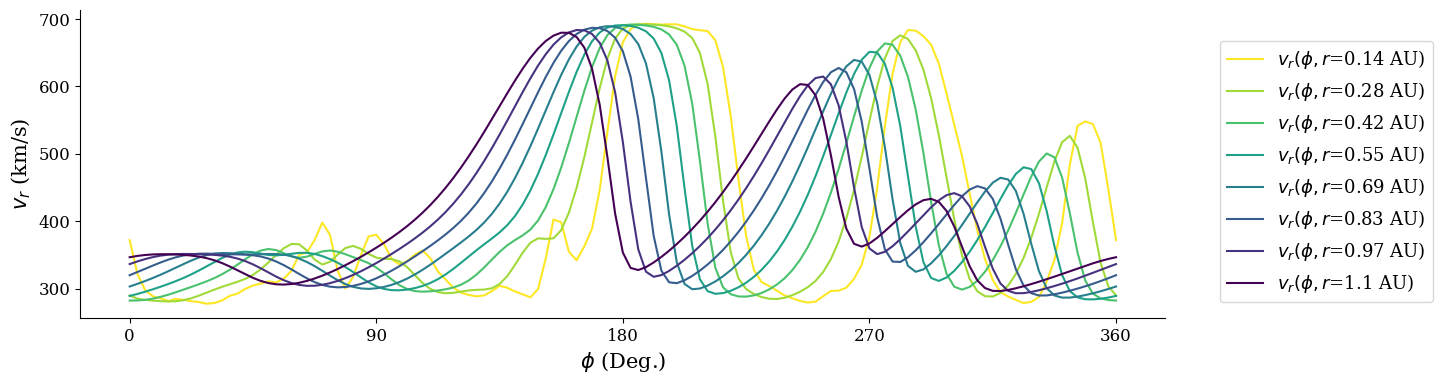

In [454]:
plot_heat_data(V, "", variable=r"$v_{r}$")

In [455]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [456]:
shift_vec = [0]
for ii in range(1, len(r)):
    corr = periodic_corr_np(V[:, 0], V[:, ii])
    shift_vec.append(-p[np.argmax(corr)]*180/np.pi)
    
n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec[:n], 1)

In [457]:
def shift_function(r, r_idx, m, b, method="cce"):
    if method=="cce":
        return m * r + b
    if method=="moc":
        return np.loadtxt('HUX/shock_curve_S1.csv', delimiter=',')[r_idx]

In [476]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, r_idx=jj, m=m, b=b, method="cce")
    # interpolate over the shifted coordinate
    V_new[:, jj] = np.interp(p + shift*(np.pi/180), p, V[:, jj], period=2*np.pi)

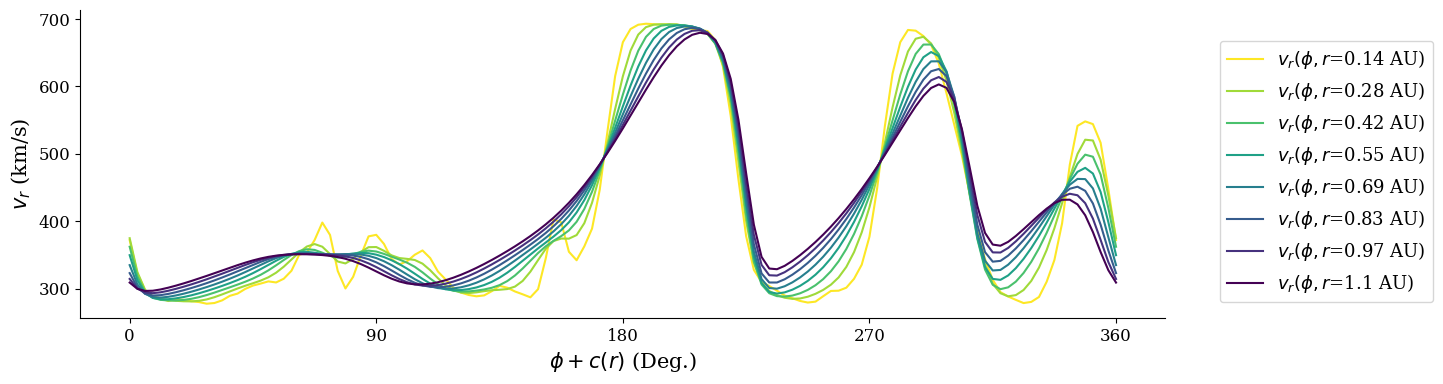

In [113]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\phi + c(r)$ (Deg.)")

In [114]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))
X=V_new

In [504]:
X_train = V_new[:l, :]
X_test = V_new[l:, :]

In [489]:
r_train = r[:l]
r_test = r[l:]
r_train.shape, r_test.shape

((98,), (42,))

In [505]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (98, 140)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (31, 140)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk
from pykoopman.common import nlse

In [ ]:
observables_pol = [lambda x: 1/x, lambda x: 1/x**2, lambda x: 1/x**3]
observable_names = [
    lambda s: f"1/{s}",
    lambda s: f"1/{s}^2",
    lambda s: f"1/{s}^3"
]

EDMD = pk.regression.EDMD()

obs = pk.observables.CustomObservables(observables_pol)

model = pk.Koopman(regressor=EDMD, observables=obs)
ti=time.time()
model.fit(X_train, dt = (r_train[1] - r_train[0]).value)
print(time.time()-ti)

0.4139719009399414


In [573]:
pol_obs = pk.observables.Polynomial(degree=2)
model = pk.Koopman(regressor=EDMD, observables=pol_obs)
ti=time.time()
model.fit(X_train, dt = (r_train[1] - r_train[0]).value)
print(time.time()-ti)

0.9292821884155273


In [562]:
obsRFF = pk.observables.RandomFourierFeatures(include_state=True,gamma=1.0,D=3)
model = pk.Koopman(observables=obsRFF, regressor=EDMD)
ti=time.time()
model.fit(X_train, dt = (r_train[1] - r_train[0]).value)
print(time.time()-ti)

0.7250566482543945


In [511]:
RBF = pk.observables.RadialBasisFunction(
    rbf_type="thinplate",
    kernel_width=1,
    polyharmonic_coeff=1.0,
    include_state=True,
)
print(X_train.shape)
model = pk.Koopman(observables=RBF, regressor=EDMD)
model.fit(X_train, dt = (r_train[1] - r_train[0]).value)

(98, 140)


Koopman(observables=RadialBasisFunction(centers=array([[692.65502951, 315.16270501, 507.59654825, ..., 593.07834926,
        431.65425206, 490.25123958],
       [390.70219002, 535.72742822, 366.08692827, ..., 493.93790469,
        692.35443848, 687.879317  ],
       [483.41915883, 692.18991967, 328.76004156, ..., 590.46977789,
        641.64126474, 580.24831015],
       ...,
       [571.32187524, 396.96251763, 424.70410684, ..., 425.21063482,
        583.83603354, 466.94300037],
       [511.36861498, 679.44005098, 369.79624043, ..., 644.27707187,
        606.31309988, 423.4243891 ],
       [679.28186632, 672.23197493, 515.46557921, ..., 625.98241041,
        537.32413333, 519.82216103]]),
                                        kernel_width=1, rbf_type='thinplate'),
        regressor=EDMD())

In [588]:
K = model.A
ti=time.time()
V_train_ROM = np.vstack((V_new[0], model.simulate(V_new[0], n_steps=V_new.shape[0] - 1)))
print(time.time()-ti)
V_train_ROM.shape

0.08673787117004395


(129, 140)

In [589]:
V_ROM_DMD = convert_from_x_to_v(X_ROM=V_train_ROM, r=r, p=p, m=m, b=b, shift_function=shift_function, method="cce")

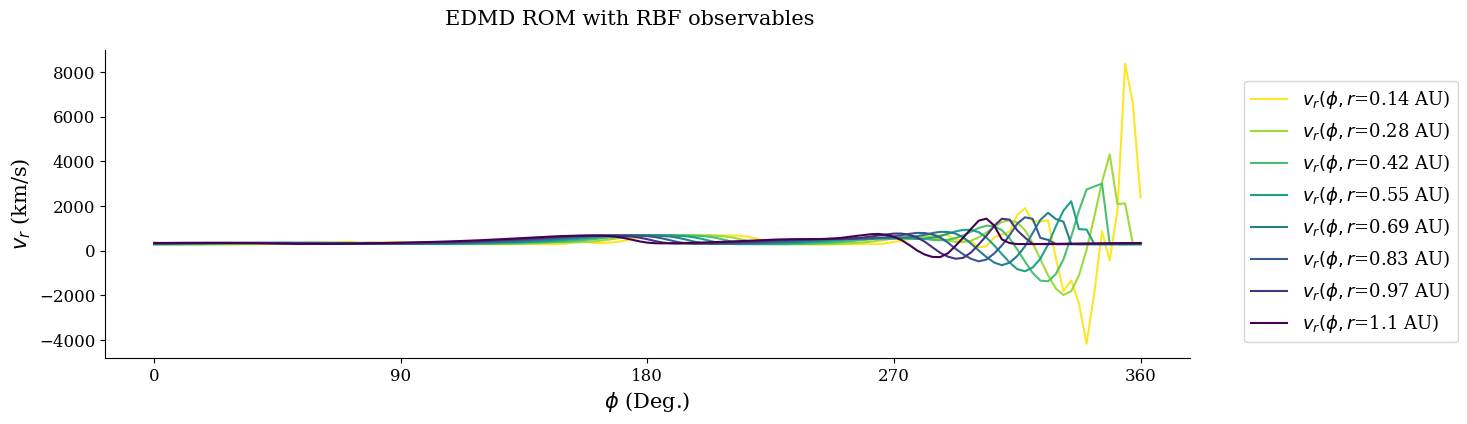

In [590]:
plot_heat_data(V_ROM_DMD, "EDMD ROM with RBF observables", variable=r"$v_{r}$")

272.8125086589165

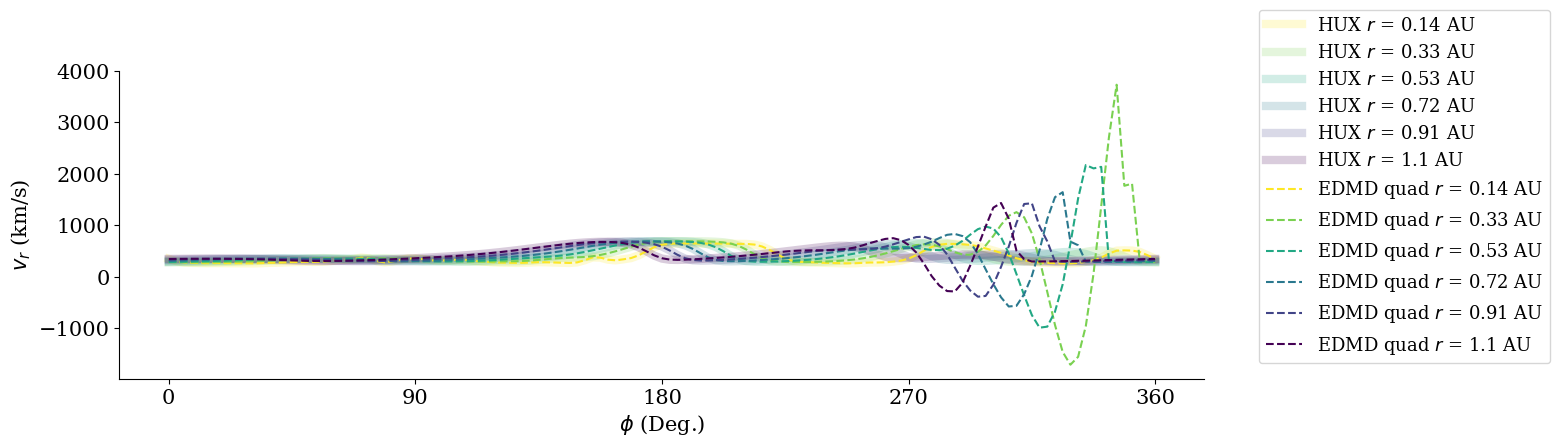

In [591]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    if j == 0:
        ax.plot(p*(180/np.pi), f[:, 55, j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    else:
        ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    if j == 0:
        ax.plot(p*(180/np.pi), f[:, 55, j], "--", color=curr_color, label=r"EDMD quad $r$ = " + 
        str(round(r[j].to(u.AU).value,2)) + " AU")
    else:
        ax.plot(p*(180/np.pi), V_ROM_DMD[:,j], "--", color=curr_color, label=rf"EDMD quad $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v_{r}$ (km/s)", fontsize=15)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=15)

# fig.savefig("HUX/figs/CR" + str(cr) + "/H/sopinf_vs_hux_H.png", dpi=500, bbox_inches='tight')
p[97]*(180/np.pi)

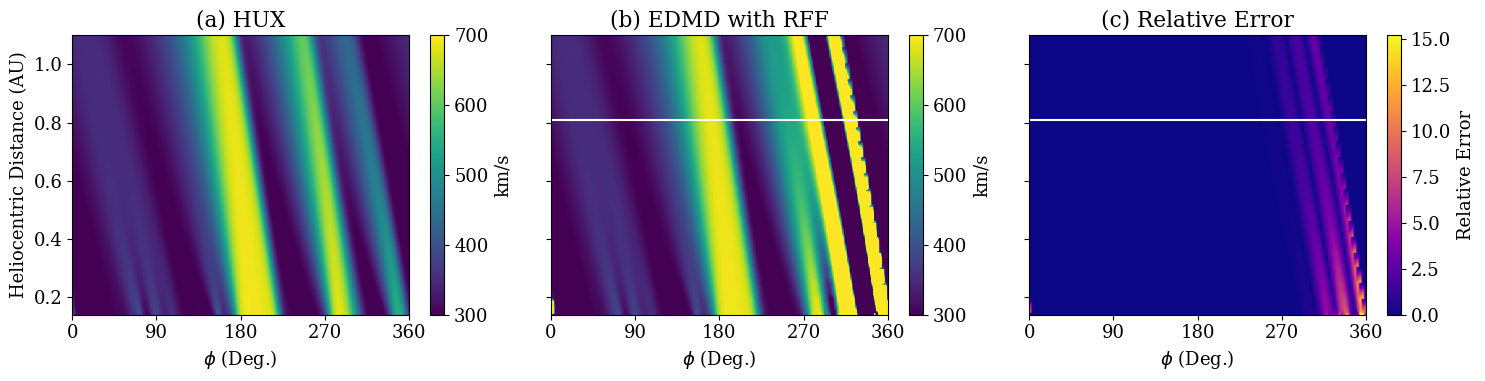

In [592]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[0].to(u.AU).value, 
                                r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) HUX")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM_DMD.T, extent=[0,360,r[0].to(u.AU).value, 
                                    r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto",  origin="lower")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) EDMD with RFF")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM_DMD.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[0].to(u.AU).value, r[-1].to(u.AU).value], 
                   cmap="plasma", aspect="auto", origin="lower")

ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.tight_layout()

# fig.savefig("HUX/figs/CR" + str(cr) + "/H/shifted_HUX_relative_error_H.png", dpi=500, bbox_inches='tight')